Imports и setup

In [1]:
import copy
import yaml
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from src.data.datasets import SyntheticSpectralDataset
from src.training.train import train
from src.data.quality_metrics import snr_mad


Загрузка конфигов

In [2]:
base_cfg = yaml.safe_load(open("../configs/base.yaml"))
data_cfg = yaml.safe_load(open("../configs/synthetic.yaml"))

def merge_cfg(base_cfg, data_cfg):
    cfg = copy.deepcopy(base_cfg)
    for key in ["data", "generator", "noise", "missing"]:
        cfg[key] = copy.deepcopy(data_cfg[key])
    return cfg


Обучение 3-х моделей

In [3]:
ATTN_MODES = {
    "vanilla": "vanilla",
    "ifa_mt": "mask_token",
    "ifa_oo": "observed_only",
}

trained_models = {}

for name, attn_mode in ATTN_MODES.items():
    print(f"\n=== Training model: {name} ({attn_mode}) ===")

    cfg = merge_cfg(base_cfg, data_cfg)
    cfg["model"]["attn_mode"] = attn_mode

    train_ds = SyntheticSpectralDataset(cfg)
    val_ds = SyntheticSpectralDataset(cfg)

    train_loader = DataLoader(
        train_ds,
        batch_size=cfg["training"]["batch_size"],
        shuffle=True,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=cfg["training"]["batch_size"],
        shuffle=False,
    )

    model = train(train_loader=train_loader, val_loader=val_loader, cfg=cfg)
    trained_models[name] = model



=== Training model: vanilla (vanilla) ===
[Epoch 000] train_loss=0.2946 | val={'accuracy': 0.9079}
[Epoch 001] train_loss=0.2968 | val={'accuracy': 0.9332}
[Epoch 002] train_loss=0.1901 | val={'accuracy': 0.9334}
[Epoch 003] train_loss=0.1383 | val={'accuracy': 0.9162}
[Epoch 004] train_loss=0.1545 | val={'accuracy': 0.886}
[Epoch 005] train_loss=0.1262 | val={'accuracy': 0.9334}
[Epoch 006] train_loss=0.1495 | val={'accuracy': 0.9524}

=== Training model: ifa_mt (mask_token) ===
[Epoch 000] train_loss=0.2764 | val={'accuracy': 0.9002}
[Epoch 001] train_loss=0.2461 | val={'accuracy': 0.9313}
[Epoch 002] train_loss=0.1675 | val={'accuracy': 0.9338}
[Epoch 003] train_loss=0.1425 | val={'accuracy': 0.9059}
[Epoch 004] train_loss=0.2147 | val={'accuracy': 0.9024}
[Epoch 005] train_loss=0.1365 | val={'accuracy': 0.9105}
[Epoch 006] train_loss=0.1594 | val={'accuracy': 0.9413}

=== Training model: ifa_oo (observed_only) ===
[Epoch 000] train_loss=0.2946 | val={'accuracy': 0.9079}
[Epoch 001

Определение binning

In [4]:
missing_edges = np.array([0.0, 0.1, 0.3, 0.6])  # 3 bins: [0-0.1), [0.1-0.3), [0.3-0.6)

def digitize_missing(mf):
    return int(np.digitize(mf, missing_edges, right=False) - 1)

def clip_bin(i, n_bins):
    return max(0, min(i, n_bins - 1))


Сбор значений SNR на evaluation сете

In [5]:
@torch.no_grad()
def collect_snr_values(loader, device="cpu"):
    snrs = []
    for batch in loader:
        x = batch["x"].to(device)       # (B, C, T)
        mask = batch["mask"].to(device) # (B, C, T)

        snr_bc = snr_mad(x, mask)               # (B, C)
        snr_b = snr_bc.mean(dim=1).cpu().numpy()  # (B,)
        snrs.append(snr_b)

    return np.concatenate(snrs, axis=0)

cfg_ref = merge_cfg(base_cfg, data_cfg)
val_ds_ref = SyntheticSpectralDataset(cfg_ref)
val_loader_ref = DataLoader(val_ds_ref, batch_size=cfg_ref["training"]["batch_size"], shuffle=False)

snr_all = collect_snr_values(val_loader_ref, device=cfg_ref["device"])
print("SNR stats:", np.min(snr_all), np.mean(snr_all), np.max(snr_all))


SNR stats: 0.2747815 0.46201944 0.74183184


In [6]:
snr_edges = np.quantile(snr_all, [0.0, 1/3, 2/3, 1.0])

snr_edges[0] -= 1e-9
snr_edges[-1] += 1e-9

def digitize_snr(snr):
    return int(np.digitize(snr, snr_edges, right=False) - 1)

print("SNR edges:", snr_edges)


SNR edges: [0.27478149 0.4311007  0.48775637 0.74183184]


Основной метод оценки: accuracy heatmap over (missing_bin × snr_bin)

In [7]:
@torch.no_grad()
def accuracy_heatmap_missing_snr(model, loader, device="mps"):
    model.eval()

    n_miss_bins = len(missing_edges) - 1
    n_snr_bins = len(snr_edges) - 1

    correct = np.zeros((n_miss_bins, n_snr_bins), dtype=np.float64)
    total   = np.zeros((n_miss_bins, n_snr_bins), dtype=np.float64)

    for batch in loader:
        x = batch["x"].to(device)
        mask = batch["mask"].to(device)
        y = batch["y"].to(device)

        logits = model(x, mask=mask)
        pred = logits.argmax(dim=1)

        mf_list = batch["meta"]["missing_fraction"]

        snr_bc = snr_mad(x, mask)              # (B, C)
        snr_b  = snr_bc.mean(dim=1).cpu().numpy()

        for i in range(len(y)):
            mf = float(mf_list[i])
            snr = float(snr_b[i])

            mi = clip_bin(digitize_missing(mf), n_miss_bins)
            si = clip_bin(digitize_snr(snr), n_snr_bins)

            total[mi, si] += 1
            correct[mi, si] += int(pred[i].item() == y[i].item())

    acc = np.divide(correct, np.maximum(total, 1.0))
    return acc, total


Оценка каждой модели

In [8]:
heatmaps = {}
counts = {}

for name, model in trained_models.items():
    print(f"Evaluating heatmap for: {name}")
    acc_map, cnt_map = accuracy_heatmap_missing_snr(model, val_loader_ref, device=cfg_ref["device"])
    heatmaps[name] = acc_map
    counts[name] = cnt_map

    print("Counts per bin:\n", cnt_map.astype(int))


Evaluating heatmap for: vanilla
Counts per bin:
 [[1303 1240 1177]
 [ 806  864  805]
 [1180 1297 1328]]
Evaluating heatmap for: ifa_mt
Counts per bin:
 [[1317 1280 1125]
 [ 842  861  826]
 [1211 1206 1332]]
Evaluating heatmap for: ifa_oo
Counts per bin:
 [[1321 1190 1178]
 [ 871  851  843]
 [1192 1247 1307]]


Plot heatmaps (accuracy)

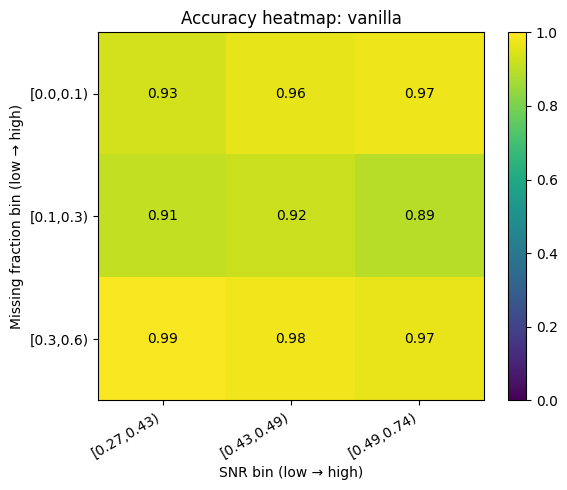

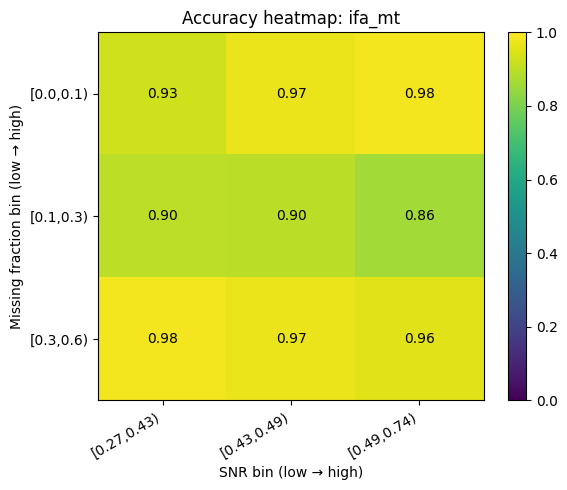

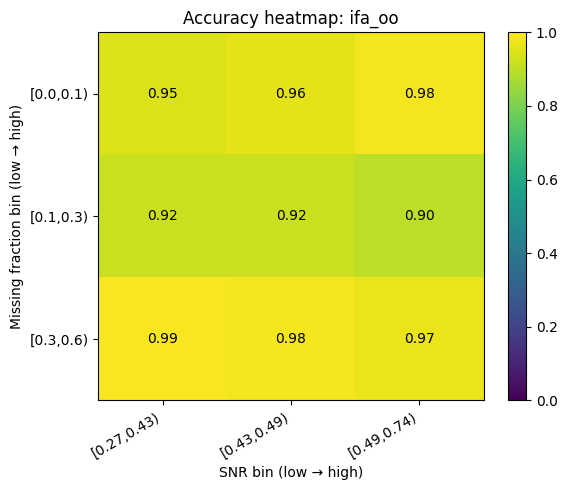

In [9]:
def plot_heatmap(acc, title):
    plt.figure(figsize=(6, 5))
    im = plt.imshow(acc, vmin=0.0, vmax=1.0, aspect="auto")
    plt.colorbar(im)

    miss_labels = [f"[{missing_edges[i]:.1f},{missing_edges[i+1]:.1f})" for i in range(len(missing_edges)-1)]
    snr_labels  = [f"[{snr_edges[i]:.2f},{snr_edges[i+1]:.2f})" for i in range(len(snr_edges)-1)]

    plt.xticks(np.arange(len(snr_labels)), snr_labels, rotation=30, ha="right")
    plt.yticks(np.arange(len(miss_labels)), miss_labels)

    plt.xlabel("SNR bin (low → high)")
    plt.ylabel("Missing fraction bin (low → high)")
    plt.title(title)

    for i in range(acc.shape[0]):
        for j in range(acc.shape[1]):
            plt.text(j, i, f"{acc[i,j]:.2f}", ha="center", va="center", color="white" if acc[i,j] < 0.5 else "black")

    plt.tight_layout()
    plt.show()


for name in ["vanilla", "ifa_mt", "ifa_oo"]:
    plot_heatmap(heatmaps[name], f"Accuracy heatmap: {name}")


Plot “delta heatmaps” (IFA vs Vanilla)

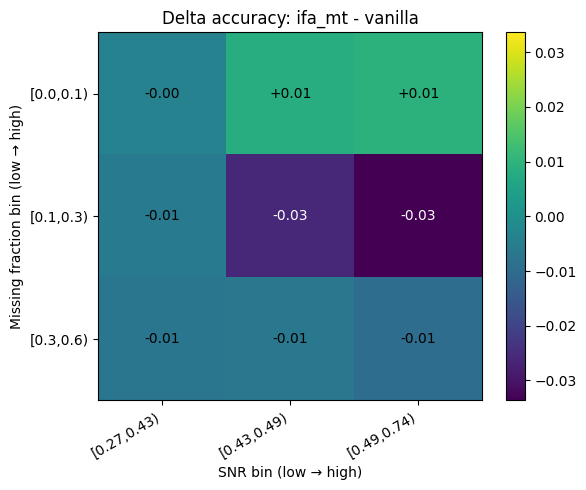

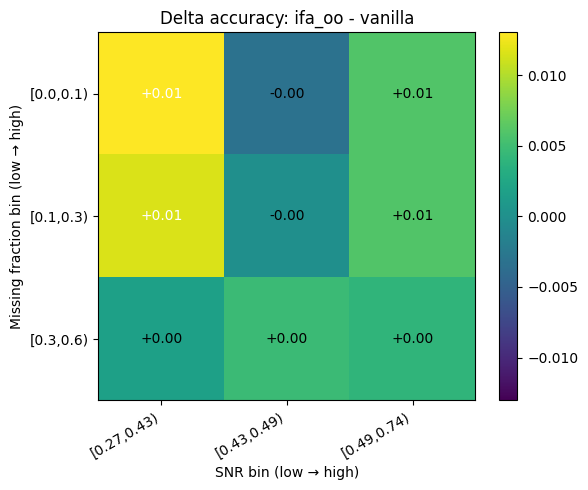

In [10]:
def plot_delta(delta, title):
    plt.figure(figsize=(6, 5))
    vmax = np.max(np.abs(delta))
    im = plt.imshow(delta, vmin=-vmax, vmax=vmax, aspect="auto")
    plt.colorbar(im)

    miss_labels = [f"[{missing_edges[i]:.1f},{missing_edges[i+1]:.1f})" for i in range(len(missing_edges)-1)]
    snr_labels  = [f"[{snr_edges[i]:.2f},{snr_edges[i+1]:.2f})" for i in range(len(snr_edges)-1)]

    plt.xticks(np.arange(len(snr_labels)), snr_labels, rotation=30, ha="right")
    plt.yticks(np.arange(len(miss_labels)), miss_labels)

    plt.xlabel("SNR bin (low → high)")
    plt.ylabel("Missing fraction bin (low → high)")
    plt.title(title)

    for i in range(delta.shape[0]):
        for j in range(delta.shape[1]):
            plt.text(j, i, f"{delta[i,j]:+.2f}", ha="center", va="center", color="white" if abs(delta[i,j]) > vmax*0.5 else "black")

    plt.tight_layout()
    plt.show()


delta_mt = heatmaps["ifa_mt"] - heatmaps["vanilla"]
delta_oo = heatmaps["ifa_oo"] - heatmaps["vanilla"]

plot_delta(delta_mt, "Delta accuracy: ifa_mt - vanilla")
plot_delta(delta_oo, "Delta accuracy: ifa_oo - vanilla")
